# Stock Price Prediction Across Market Sectors

This project applies machine learning to the problem of stock price prediction, with an emphasis on sector-level diversity and company-level representation. The analysis covers all 11 sectors defined by the Global Industry Classification Standard (GICS). For each sector, a leading stock has been selected from a predefined list of 22 well-established and widely traded companies.

The goal is to develop a generalizable and reproducible prediction pipeline, while gaining insight into the behavior of stocks across different industries. 

### GICS Sectors Covered:
- Information Technology  
- Health Care  
- Financials  
- Consumer Discretionary  
- Communication Services  
- Industrials  
- Consumer Staples  
- Energy  
- Utilities  
- Real Estate  
- Materials


### 📈 Dataset

This project uses historical daily stock price data downloaded using the [Yahoo Finance API](https://pypi.org/project/yfinance/). The dataset includes Adjusted Close, Open, High, Low, Volume, and Close prices.

We selected 23 companies across 11 sectors of the US stock market:

| Sector                    | Tickers         |
|--------------------------|------------------|
| Information Technology   | AAPL, MSFT, NVDA |
| Health Care              | JNJ, UNH         |
| Financials               | JPM, BAC         |
| Consumer Discretionary   | AMZN, TSLA       |
| Communication Services   | GOOGL, META      |
| Industrials              | UNP, RTX         |
| Consumer Staples         | PG, KO           |
| Energy                   | XOM, CVX         |
| Utilities                | NEE, DUK         |
| Real Estate              | AMT, PLD         |
| Materials                | LIN, SHW         |

These companies were selected due to their market leadership, high liquidity, and rich historical data. They serve as strong representatives of their sectors and offer a diverse foundation for building and evaluating time series forecasting models.

Raw data is saved in `data/raw/` as individual CSV files.


### Feature Engineering: 

Extensive Feature engineering is covered in the 03_feature_engineering.py script (included in the src folder). The script adds ~200 features including some of the most ultilised trading indicators. Below is just a snapshot of some that are covered:

- High-Low
- Price-Open
- lag features for closing price
- Volume and volatility indicators
- EMA, SMA, Bolinger Bands
- Swing direction & bespoke W.D. Gann inspired features
- Index (NASDAQ and SP500) derived features

### Exploratory Data Analysis to guide modeling strategy

Before we move on to modelling and price predictions, it would be a good idea to consider the following question: How many models to build?
In order to help address this problem we will consider the following scenarios: 

1. If stocks cluster clearly by sector or behavior

    🏢 <span style="color:lime">We will build per-sector models </span>

2. If each stock behaves uniquely

    📈 <span style="color:purple">We will build stock-specific modelss </span>

3. If patterns are consistent across stocks

    🌐 <span style="color:orange">We will build one unified model. </span>

### Let's start exploring the data 

First let's load and merge individual stock data to examine overarching patterns and similarities or differences between stocks in different categories

In [1]:
import pandas as pd
from pathlib import Path

# Load and merge individual stock data
input_folder = Path("/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/data/merged")
all_data = []

for file in input_folder.glob("*.csv"):
    ticker = file.stem  # assumes filename is the ticker or contains it
    df = pd.read_csv(file, parse_dates=['Date'])
    df['TICKER'] = ticker
    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)
print(f"The size of the merged DataFrame is: {merged_df.shape}")
print("---------------------------------------------------------------------------------------------------------------------")
print("The first few rows of the merged DataFrame:")    
merged_df.head()



The size of the merged DataFrame is: (141049, 155)
---------------------------------------------------------------------------------------------------------------------
The first few rows of the merged DataFrame:


,Date,TICKER,Sector,MarketCap,MarketCapBin,Close,High,Low,Open,Volume,...,Target_Raw_Close_21d,Target_%_Return_7d,Target_Log_Return_7d,Target_Direction_7d,Target_%_Return_14d,Target_Log_Return_14d,Target_Direction_14d,Target_%_Return_21d,Target_Log_Return_21d,Target_Direction_21d
0,1999-12-01,BAC,Financials,368534880256,Large Cap,15.007504,15.299226,14.813022,14.813022,9380200,...,13.014065,-0.073434,-0.076270,0,-0.147948,-0.160108,0,-0.132829,-0.142520,0
1,1999-12-02,BAC,Financials,368534880256,Large Cap,14.618542,15.088539,14.391646,14.877851,12395600,...,12.560280,-0.066241,-0.068537,0,-0.139689,-0.150462,0,-0.140798,-0.151751,0
2,1999-12-03,BAC,Financials,368534880256,Large Cap,14.894052,15.104740,14.813018,14.877845,14423800,...,11.814767,-0.109902,-0.116423,0,-0.140370,-0.151253,0,-0.206746,-0.231612,0
3,1999-12-06,BAC,Financials,368534880256,Large Cap,14.351131,14.748198,14.132339,14.553717,13820000,...,11.944418,-0.084698,-0.088501,0,-0.114624,-0.121743,0,-0.167702,-0.183565,0
4,1999-12-07,BAC,Financials,368534880256,Large Cap,13.613721,14.245787,13.548894,14.213373,20245200,...,12.965451,-0.044048,-0.045047,0,-0.060714,-0.062636,0,-0.047619,-0.048790,0


We can now list and confirm the number of stocks we have in the merged dataset

In [2]:
# List and confirm the number of stocks in the merged dataset
print(f"The number of unique stocks in the merged dataset is: {merged_df['TICKER'].nunique()}")
print("---------------------------------------------------------------------------------------------------------------------")
print("The unique stocks in the merged dataset are:")
print(merged_df['TICKER'].unique())

The number of unique stocks in the merged dataset is: 23
---------------------------------------------------------------------------------------------------------------------
The unique stocks in the merged dataset are:
['BAC' 'UNP' 'AMT' 'PG' 'AMZN' 'KO' 'NEE' 'MSFT' 'SHW' 'RTX' 'NVDA' 'XOM'
 'CVX' 'PLD' 'LIN' 'JPM' 'TSLA' 'GOOGL' 'META' 'DUK' 'UNH' 'AAPL' 'JNJ']


Let's confirm the number of features we have to explore?

In [3]:
# Print Number of features
print(f"Number of features: {len(merged_df.columns)}")
print("---------------------------------------------------------------------------------------------------------------------")

# Print list of features
columns = merged_df.columns.tolist()
print("List of features (10 per line):")
for i in range(0, len(columns), 10):
    print(columns[i:i+10])

Number of features: 155
---------------------------------------------------------------------------------------------------------------------
List of features (10 per line):
['Date', 'TICKER', 'Sector', 'MarketCap', 'MarketCapBin', 'Close', 'High', 'Low', 'Open', 'Volume']
['NASDAQ_return_1', 'NASDAQ_return_5', 'NASDAQ_return_10', 'NASDAQ_return_20', 'NASDAQ_lag_1', 'NASDAQ_lag_5', 'NASDAQ_lag_10', 'NASDAQ_lag_20', 'SP500_return_1', 'SP500_return_5']
['SP500_return_10', 'SP500_return_20', 'SP500_lag_1', 'SP500_lag_5', 'SP500_lag_10', 'SP500_lag_20', 'High-Low', 'Price-Open', 'open_to_close_return', 'high_to_close_return']
['day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'avg_volume_20', 'volume_norm', 'rolling_vwap_20']
['RollingMean_5', 'RollingStd_5', 'RollingMean_10', 'RollingStd_10', 'RollingMean_20', 'RollingStd_20', 'RollingMean_30', 'RollingStd_30', 'RollingMean_60', 'RollingStd_60']
['RollingMean_90', 'Rolli

### Calculate Basic Summary Statistics for our dataset

In [4]:
# Check for missing values
print("---------------------------------------------------------------------------------------------------------------------")
print("Checking for missing values in the merged DataFrame:")
missing_values = merged_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("Missing values found in the following columns:")
    print(missing_values)
else:
    print("No missing values found in the merged DataFrame.")

---------------------------------------------------------------------------------------------------------------------
Checking for missing values in the merged DataFrame:
Missing values found in the following columns:
NASDAQ_return_1           20
NASDAQ_return_5          100
NASDAQ_return_10         200
NASDAQ_return_20         400
NASDAQ_lag_1              20
                        ... 
Target_Log_Return_7d     161
Target_%_Return_14d      322
Target_Log_Return_14d    322
Target_%_Return_21d      483
Target_Log_Return_21d    483
Length: 101, dtype: int64


Chek the General Data Set Information (after remving NAs)

In [5]:
# Remove NAs if any
merged_df.dropna(inplace=True)
# Check the General Data Set Information
# Data set information
print("---------------------------------------------------------------------------------------------------------------------")
print("General Data Set Information:")
print(merged_df.info()) 
# print the total number of missing values per column
print("---------------------------------------------------------------------------------------------------------------------")
print("Total number of missing values per column:")
print(merged_df.isnull().sum())
# Print total number of NAs in the dataset
print("---------------------------------------------------------------------------------------------------------------------")
print(f"Total number of NAs in the dataset: {merged_df.isnull().sum().sum()}")

---------------------------------------------------------------------------------------------------------------------
General Data Set Information:
<class 'pandas.core.frame.DataFrame'>
Index: 135989 entries, 199 to 141027
Columns: 155 entries, Date to Target_Direction_21d
dtypes: bool(2), datetime64[ns](1), float64(112), int64(34), object(6)
memory usage: 160.0+ MB
None
---------------------------------------------------------------------------------------------------------------------
Total number of missing values per column:
Date                     0
TICKER                   0
Sector                   0
MarketCap                0
MarketCapBin             0
                        ..
Target_Log_Return_14d    0
Target_Direction_14d     0
Target_%_Return_21d      0
Target_Log_Return_21d    0
Target_Direction_21d     0
Length: 155, dtype: int64
---------------------------------------------------------------------------------------------------------------------
Total number of NAs in t

In [6]:
# Print basic summary statistics
print("---------------------------------------------------------------------------------------------------------------------")
print("Basic Summary Statistics:")
summary_stats = merged_df.describe()
print(summary_stats)

---------------------------------------------------------------------------------------------------------------------
Basic Summary Statistics:
                                Date     MarketCap          Close  \
count                         135989  1.359890e+05  135989.000000   
mean   2013-06-05 21:21:54.926942208  9.492488e+11      66.801314   
min              2000-09-14 00:00:00  8.871275e+10       0.056316   
25%              2007-05-17 00:00:00  1.520916e+11      17.100143   
50%              2013-08-30 00:00:00  3.071097e+11      36.054268   
75%              2019-07-17 00:00:00  1.015730e+12      83.112457   
max              2025-06-03 00:00:00  3.885920e+12     735.449280   
std                              NaN  1.223341e+12      83.846912   

                High            Low           Open        Volume  \
count  135989.000000  135989.000000  135989.000000  1.359890e+05   
mean       67.479350      66.083810      66.786410  6.903722e+07   
min         0.060213       0.0

In [7]:
# Describe by Ticker Close Price
print("---------------------------------------------------------------------------------------------------------------------")
print("Basic Summary Statistics by Ticker:")
summary_stats_by_ticker = merged_df.groupby('TICKER')['Close'].describe()
print(summary_stats_by_ticker)

---------------------------------------------------------------------------------------------------------------------
Basic Summary Statistics by Ticker:
         count        mean         std        min         25%         50%  \
TICKER                                                                      
AAPL    6216.0   45.318619   64.214954   0.197156    2.498029   16.062744   
AMT     6216.0   85.070500   76.095046   0.528808   24.233961   56.151558   
AMZN    6216.0   47.675227   61.760591   0.298500    2.436750   12.957250   
BAC     6216.0   21.950795   10.139365   2.456463   12.840222   21.885767   
CVX     6216.0   65.248279   39.984901  13.218486   32.717810   61.422657   
DUK     6216.0   46.520390   28.110940   7.578616   22.903535   40.021980   
GOOGL   5032.0   51.909135   48.749870   6.404035   13.806090   29.743120   
JNJ     6216.0   75.311287   46.052570  21.800550   36.229409   51.753363   
JPM     6216.0   61.555592   54.172620   8.166406   23.809034   33.285286   

### Now Compare Agreement between Timeframes & Standardise for all Stocks

In [8]:
# Ensure 'Date' column is datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Get date range per TICKER
stock_ranges = merged_df.groupby('TICKER')['Date'].agg(start='min', end='max').reset_index()

print("🗓️ Available timeframe per stock:")
print(stock_ranges)


🗓️ Available timeframe per stock:
   TICKER      start        end
0    AAPL 2000-09-14 2025-06-03
1     AMT 2000-09-14 2025-06-03
2    AMZN 2000-09-14 2025-06-03
3     BAC 2000-09-14 2025-06-03
4     CVX 2000-09-14 2025-06-03
5     DUK 2000-09-14 2025-06-03
6   GOOGL 2005-06-03 2025-06-03
7     JNJ 2000-09-14 2025-06-03
8     JPM 2000-09-14 2025-06-03
9      KO 2000-09-14 2025-06-03
10    LIN 2000-09-14 2025-06-03
11   META 2013-03-07 2025-06-03
12   MSFT 2000-09-14 2025-06-03
13    NEE 2000-09-14 2025-06-03
14   NVDA 2000-09-14 2025-06-03
15     PG 2000-09-14 2025-06-03
16    PLD 2000-09-14 2025-06-03
17    RTX 2000-09-14 2025-06-03
18    SHW 2000-09-14 2025-06-03
19   TSLA 2011-04-12 2025-06-03
20    UNH 2000-09-14 2025-06-03
21    UNP 2000-09-14 2025-06-03
22    XOM 2000-09-14 2025-06-03


The great mojority of stock have data going back all the way back to 1999. Unfortunately, Google (GOOGL), Facebook (META), and Tesla (TSLA) are the exceptions. In order to get the exact range for all stocks we will need to focus on the time frame define by the "youngest" company in the data set: (META) for which price history dates back to 07-03-2013. We will use this date a the starting point for all stock. 

In [22]:
# Define your desired start date - here based on META's cutoff date
cutoff_date = pd.to_datetime("2013-03-07")

# Filter merged_df to only include data on or after the cutoff
merged_df = merged_df[merged_df['Date'] >= cutoff_date]

# View the timeframe after filtering
print("Filtered merged_df shape:", merged_df.shape)
print("🗓️ Final start dates by stock:")
print(merged_df.groupby('TICKER')['Date'].agg(start='min', end='max').reset_index())

Filtered merged_df shape: (70840, 155)
🗓️ Final start dates by stock:
   TICKER      start        end
0    AAPL 2013-03-07 2025-06-03
1     AMT 2013-03-07 2025-06-03
2    AMZN 2013-03-07 2025-06-03
3     BAC 2013-03-07 2025-06-03
4     CVX 2013-03-07 2025-06-03
5     DUK 2013-03-07 2025-06-03
6   GOOGL 2013-03-07 2025-06-03
7     JNJ 2013-03-07 2025-06-03
8     JPM 2013-03-07 2025-06-03
9      KO 2013-03-07 2025-06-03
10    LIN 2013-03-07 2025-06-03
11   META 2013-03-07 2025-06-03
12   MSFT 2013-03-07 2025-06-03
13    NEE 2013-03-07 2025-06-03
14   NVDA 2013-03-07 2025-06-03
15     PG 2013-03-07 2025-06-03
16    PLD 2013-03-07 2025-06-03
17    RTX 2013-03-07 2025-06-03
18    SHW 2013-03-07 2025-06-03
19   TSLA 2013-03-07 2025-06-03
20    UNH 2013-03-07 2025-06-03
21    UNP 2013-03-07 2025-06-03
22    XOM 2013-03-07 2025-06-03


We can now Visualize Gantt Chart of Stock Start Dates


In [21]:
import plotly.express as px

# Prepare data
stock_ranges = merged_df.groupby("TICKER")["Date"].agg(start="min", end="max").reset_index()

# Create the timeline plot
fig = px.timeline(stock_ranges, x_start="start", x_end="end", y="TICKER", title="Stock Data Availability")

# Reverse Y-axis so earliest stock is at the top
fig.update_yaxes(autorange="reversed")

# Force all ticker labels to show
fig.update_yaxes(
    tickmode='array',
    tickvals=stock_ranges['TICKER'],  # All tickers
    ticktext=stock_ranges['TICKER']
)

# Increase figure height to avoid overlapping
fig.update_layout(height=22 * len(stock_ranges))  # ~30px per row

# Show the plot
fig.show()



### Visual Data Exploration

‼️ But before we proceed we will split the data into train, validation and test sets and do feature engineering on train set ONLY to avoid data leakage

In [23]:
# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Split by Date
train_df = merged_df[merged_df['Date'] < '2021-01-01']
valid_df = merged_df[(merged_df['Date'] >= '2021-01-01') & (merged_df['Date'] < '2023-01-01')]
test_df  = merged_df[merged_df['Date'] >= '2023-01-01']

print(f"Train: {train_df.shape}, Val: {valid_df.shape}, Test: {test_df.shape}")

Train: (45333, 155), Val: (11569, 155), Test: (13938, 155)


1. View Sectors with representative stocks

In [24]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Group by sector and pick one random TICKER per sector
representative_stocks = (
    train_df.groupby('Sector')['TICKER']
    .apply(lambda x: np.random.choice(x.unique()))
    .reset_index()
    .rename(columns={'TICKER': 'Representative_TICKER'})
)

print(representative_stocks)

                    Sector Representative_TICKER
0   Communication Services                 GOOGL
1   Consumer Discretionary                  TSLA
2         Consumer Staples                    PG
3                   Energy                   XOM
4               Financials                   BAC
5              Health Care                   JNJ
6              Industrials                   UNP
7   Information Technology                  MSFT
8                Materials                   SHW
9              Real Estate                   PLD
10               Utilities                   NEE


2. Plots Stocks over time

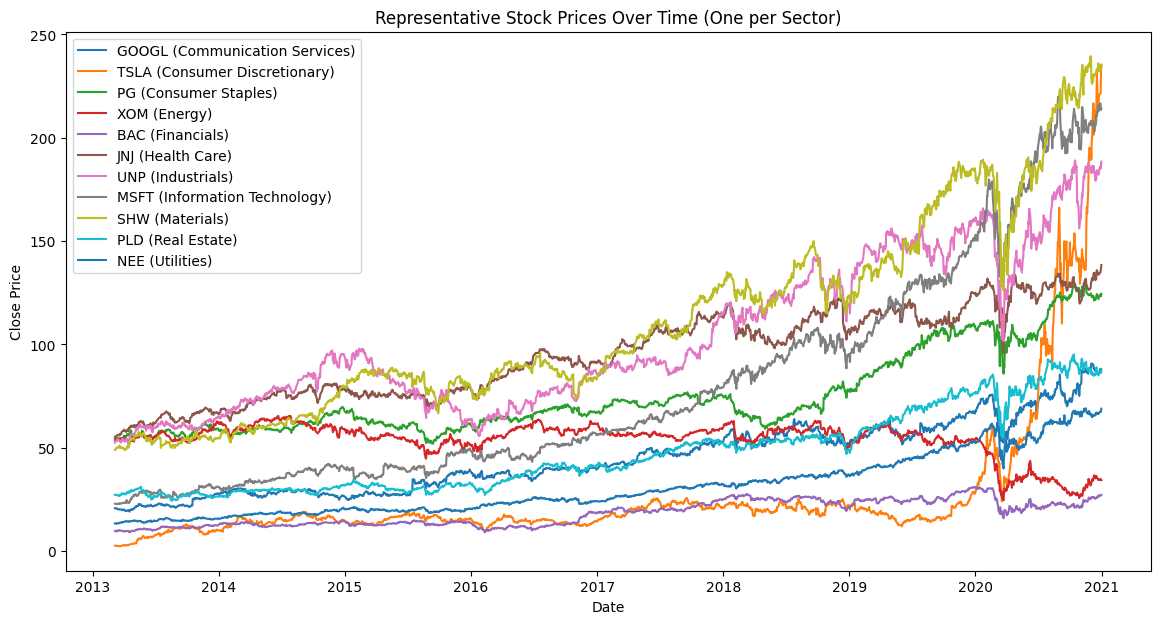

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for i, row in representative_stocks.iterrows():
    ticker = row['Representative_TICKER']
    sector = row['Sector']
    stock_data = train_df[train_df['TICKER'] == ticker]
    plt.plot(stock_data['Date'], stock_data['Close'], label=f"{ticker} ({sector})")

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Representative Stock Prices Over Time (One per Sector)')
plt.legend()
plt.show()

3. Let's examine a box plot of daily returns by sector

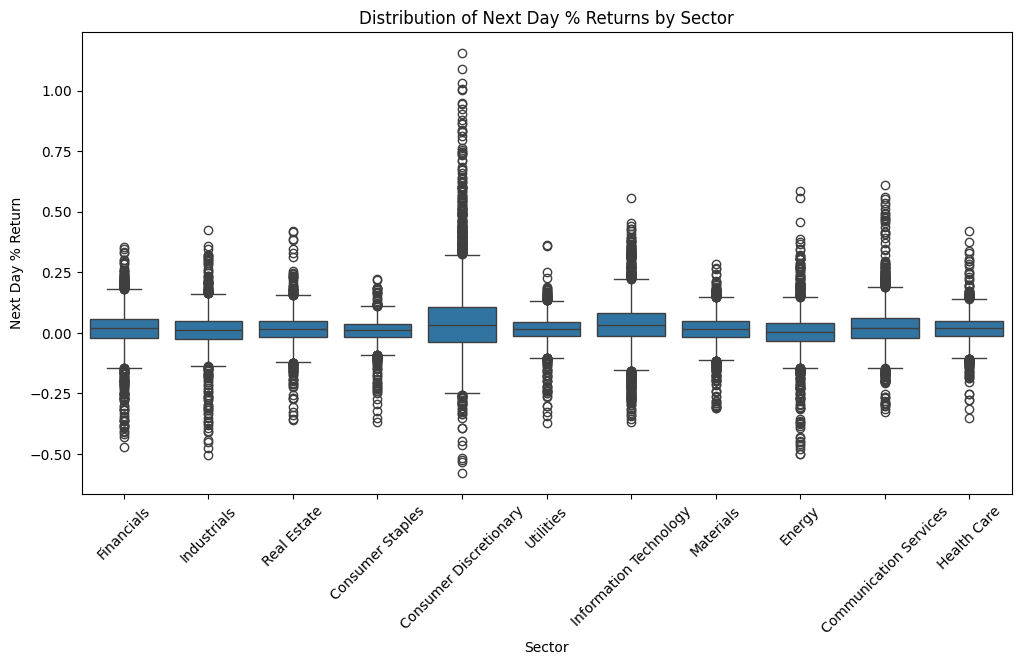

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(x='Sector', y='Target_%_Return_21d', data=train_df)
plt.xticks(rotation=45)
plt.title('Distribution of Next Day % Returns by Sector')
plt.ylabel('Next Day % Return')
plt.show()

4. Correlation heatmap vs target returns

In [29]:
# Select only numeric columns for correlation
numeric_cols = train_df.select_dtypes(include='number')

# Print list of numeric features
columns = numeric_cols.columns.tolist()
print("List of numeric features (8 per line):")
for i in range(0, len(columns), 8):
    print(columns[i:i+8])

List of numeric features (8 per line):
['MarketCap', 'Close', 'High', 'Low', 'Open', 'Volume', 'NASDAQ_return_1', 'NASDAQ_return_5']
['NASDAQ_return_10', 'NASDAQ_return_20', 'NASDAQ_lag_1', 'NASDAQ_lag_5', 'NASDAQ_lag_10', 'NASDAQ_lag_20', 'SP500_return_1', 'SP500_return_5']
['SP500_return_10', 'SP500_return_20', 'SP500_lag_1', 'SP500_lag_5', 'SP500_lag_10', 'SP500_lag_20', 'High-Low', 'Price-Open']
['open_to_close_return', 'high_to_close_return', 'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start']
['is_year_end', 'avg_volume_20', 'volume_norm', 'rolling_vwap_20', 'RollingMean_5', 'RollingStd_5', 'RollingMean_10', 'RollingStd_10']
['RollingMean_20', 'RollingStd_20', 'RollingMean_30', 'RollingStd_30', 'RollingMean_60', 'RollingStd_60', 'RollingMean_90', 'RollingStd_90']
['RollingMean_180', 'RollingStd_180', 'Return_1', 'Return_5', 'Return_10', 'Return_20', 'roc_7', 'acceleration_7']
['roc_14', 'acceleration_14', 'roc_36', 'acceleration

4. Heatmap: Correlation of features with select target columns

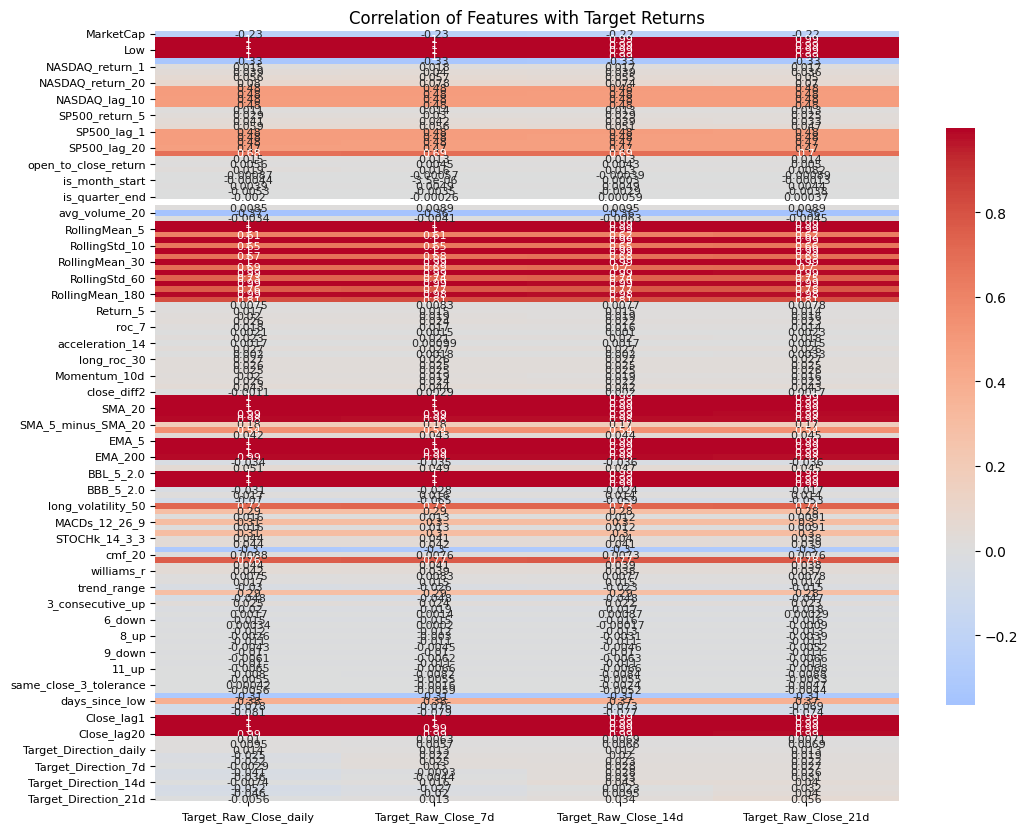

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_cols = numeric_cols = train_df.select_dtypes(include='number').select_dtypes(include='number')
corr = numeric_cols.corr()

# Adjust target names
targets = [
    'Target_Raw_Close_daily', 
    'Target_Raw_Close_7d', 
    'Target_Raw_Close_14d', 
    'Target_Raw_Close_21d',
]

# Filter only existing targets (safe)
existing_targets = [col for col in targets if col in corr.columns]

if existing_targets:
    corr_with_targets = corr[existing_targets].drop(existing_targets, errors='ignore')
    plt.figure(figsize=(12,10))
    sns.heatmap(
        corr_with_targets, 
        annot=True, 
        cmap='coolwarm', 
        center=0,
        annot_kws={"size": 8},       # smaller annotation font
        cbar_kws={"shrink": 0.75}   # optional: smaller colorbar
    )
    plt.title('Correlation of Features with Target Returns', fontsize=12)   # smaller title font
    plt.xticks(fontsize=8)   # smaller x-axis labels
    plt.yticks(fontsize=8)   # smaller y-axis labels
    plt.show()
else:
    print("No target columns found in correlation matrix.")

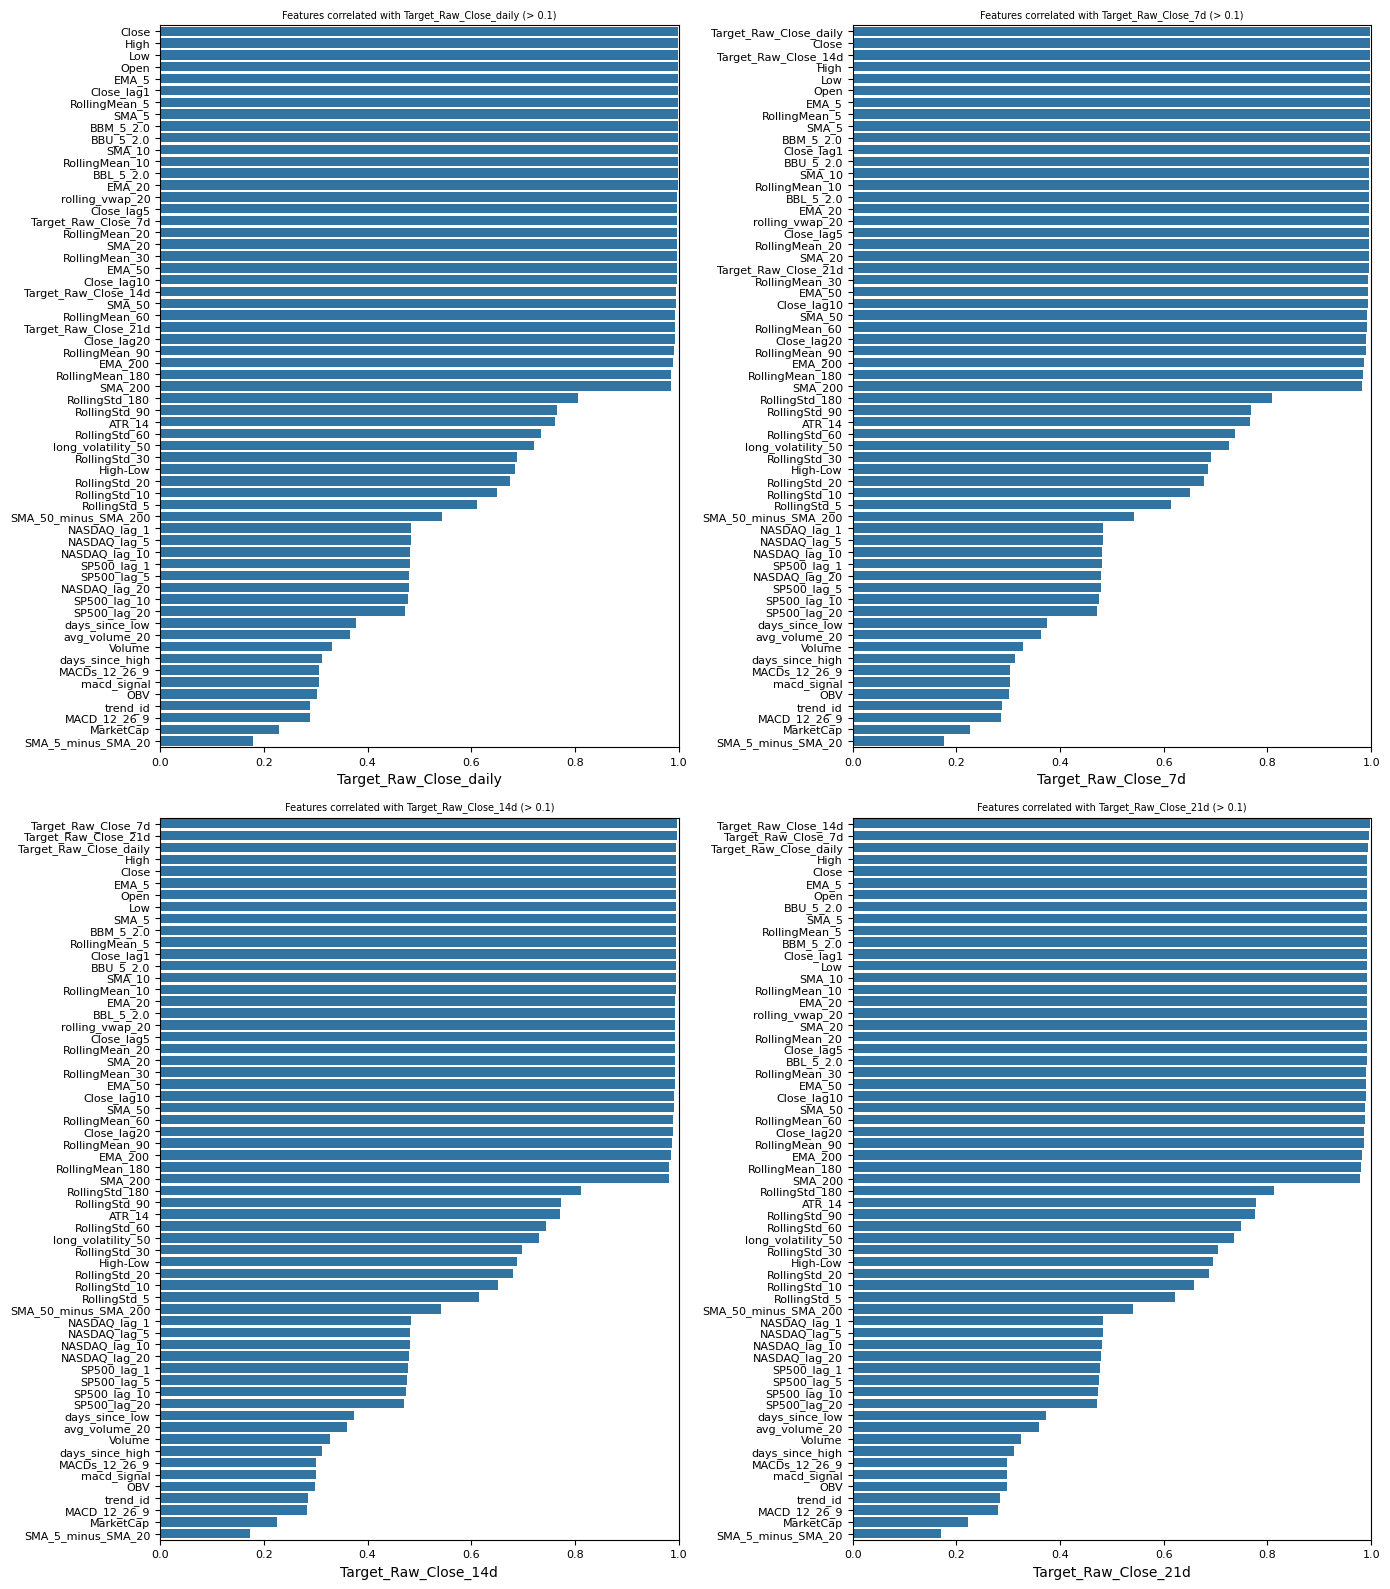

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

threshold = 0.1  # adjust as needed
existing_targets = [col for col in targets if col in corr.columns]

# Set up a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 16))
axes = axes.flatten()

for idx, target in enumerate(existing_targets):
    if idx >= 4:
        break  # fits only first 4 targets
    
    ax = axes[idx]
    abs_corr = corr[target].abs().sort_values(ascending=False)
    filtered_features = abs_corr[abs_corr > threshold].index.tolist()
    filtered_features = [f for f in filtered_features if f != target]
    
    if filtered_features:
        sns.barplot(x=abs_corr[filtered_features], y=filtered_features, ax=ax, orient='h')
        ax.set_title(f'Features correlated with {target} (> {threshold})', fontsize=7)
        ax.tick_params(axis='both', which='major', labelsize=8)
    else:
        ax.text(0.5, 0.5, f'No features > {threshold}', 
                horizontalalignment='center', verticalalignment='center', fontsize=9)
        ax.set_title(f'{target}', fontsize=10)
    ax.set_xlim(0, 1)

# Hide unused subplots if less than 4 targets
for j in range(idx+1, 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


5. Plot a heatmap of correlations between features to start exploring the relationships and potential redundancies between Features

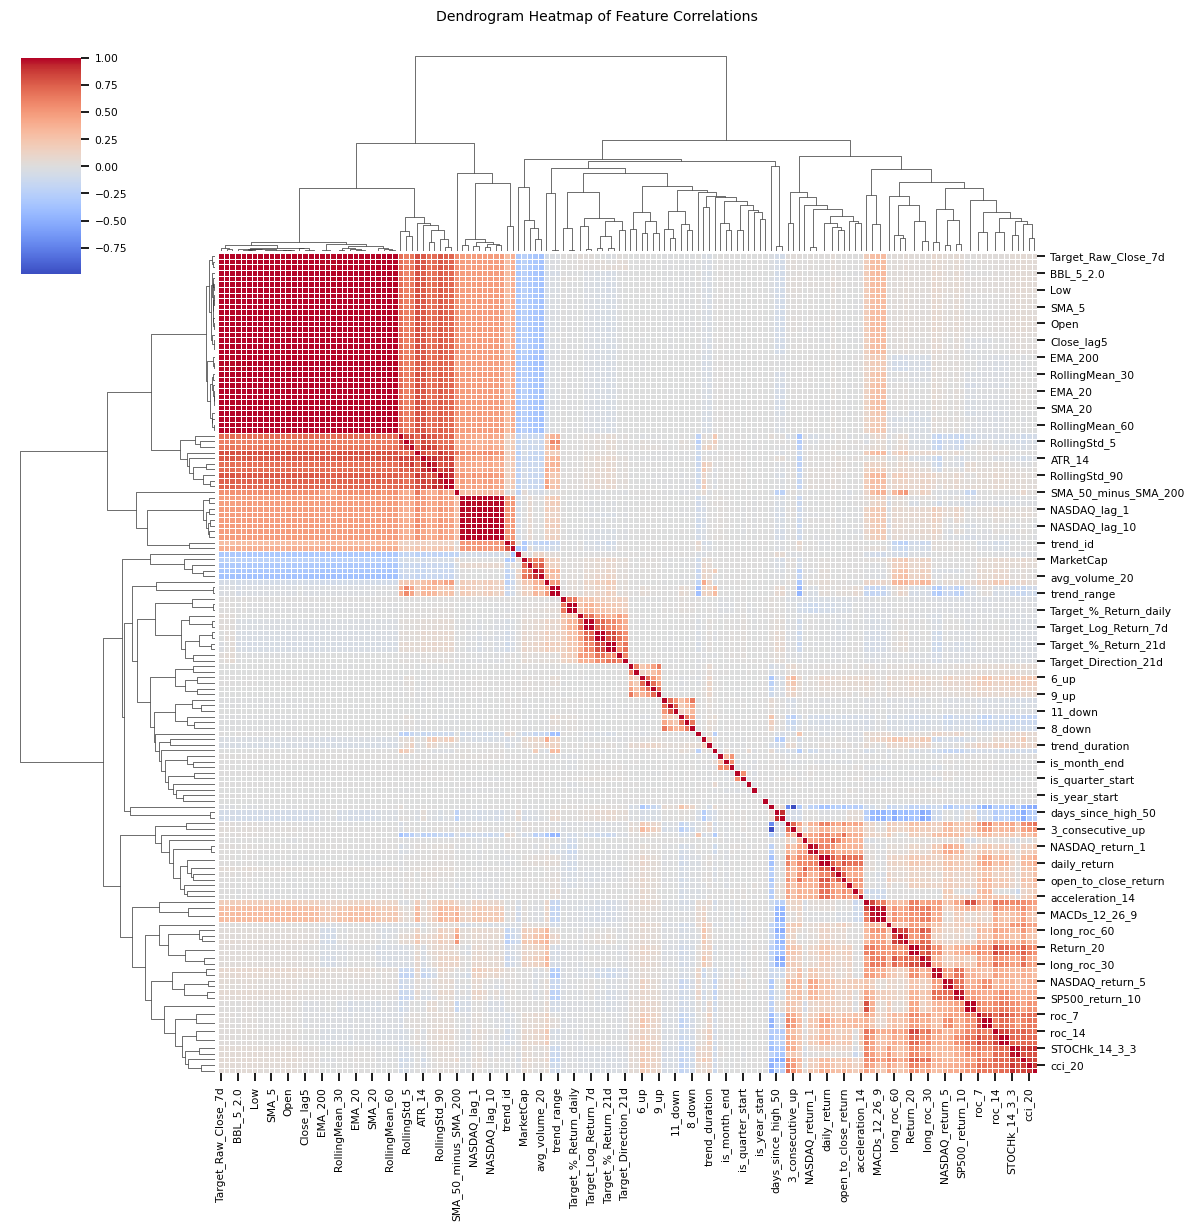

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
feature_corr_matrix = (
    train_df
    .drop(columns=["Date", "TICKER"], errors='ignore')
    .select_dtypes(include='number')
    .corr()
)

# Fill any NaNs with 0 to avoid clustermap errors
feature_corr_matrix = feature_corr_matrix.fillna(0)

# Set smaller font scale
sns.set_context("notebook", font_scale=0.7)  # Adjust font_scale to desired size (e.g., 0.7)

# Plot clustered heatmap
g = sns.clustermap(
    feature_corr_matrix,
    cmap="coolwarm",
    figsize=(12, 12),
    center=0,
    linewidths=0.5,
    annot=False
)
plt.suptitle("Dendrogram Heatmap of Feature Correlations", y=1.02)

plt.show()

‼️ Setup feature sets (drop non-features)

In [34]:
# Drop identifiers & target from X
drop_cols = ['Date', 'Close', 'Open', 'Volume', 'Target_%_Return_21d']

X_train = train_df.drop(columns=drop_cols)
X_valid = valid_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

# Store target separately
y_train = train_df['Target_%_Return_21d']
y_valid = valid_df['Target_%_Return_21d']
y_test  = test_df['Target_%_Return_21d']


### PCA Analysis for dimensionality reduction on TRAIN test set ONLY!

First we will automatically detect different categories of features and handle and/or normalise as per recommendation for each of the categories

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Automatic feature detection

# Identify categorical features (usually object or category dtype)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical features (float and int)
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Further split numerical into discrete (few unique values) and continuous (many unique values)
discrete_features = []
continuous_features = []
for col in numerical_features:
    nunique = X_train[col].nunique()
    if nunique < 20:  # threshold can be adjusted
        discrete_features.append(col)
    else:
        continuous_features.append(col)

def print_features_in_lines(feature_list, title, per_line=10):
    print("---------------------------------------------------------------------------------------------------------------------")
    print(f"{title}:")
    for i in range(0, len(feature_list), per_line):
        print(", ".join(feature_list[i:i+per_line]))
    print("---------------------------------------------------------------------------------------------------------------------")

print_features_in_lines(categorical_features, "Categorical features")
print_features_in_lines(discrete_features, "Discrete numerical features")
print_features_in_lines(continuous_features, "Continuous numerical features")

---------------------------------------------------------------------------------------------------------------------
Categorical features:
TICKER, Sector, MarketCapBin, swing_direction, swing_trend, swing_trend_shift
---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Discrete numerical features:
day_of_week, is_month_start, is_month_end, is_quarter_start, is_quarter_end, is_year_start, is_year_end, 3_consecutive_up, 3_consecutive_down, 6_up
6_down, 7_up, 7_down, 8_up, 8_down, 9_up, 9_down, 10_up, 10_down, 11_up
11_down, same_close_3, same_close_3_tolerance, is_gann_date, Target_Direction_daily, Target_Direction_7d, Target_Direction_14d, Target_Direction_21d
---------------------------------------------------------------------------------------------------------------------
------------------------------

Before proceeding to PCA analysis we need to drop ALL target columns and other features that could leak the information to our model cauing it to overfit

In [37]:
# Target columns
target_columns = [
    'Target_Raw_Close_daily', 
    'Target_Raw_Close_7d', 
    'Target_Raw_Close_14d', 
    'Target_Raw_Close_21d',
    'Target_%_Return_daily',
    'Target_%_Return_7d',
    'Target_%_Return_14d',
    'Target_%_Return_21d',
    'Target_Log_Return_daily',
    'Target_Log_Return_7d',
    'Target_Log_Return_14d',
    'Target_Log_Return_21d',    
    'Target_Direction_daily',
    'Target_Direction_7d',
    'Target_Direction_14d',
    'Target_Direction_21d'
]

# Risky features
risky_features = ['Open', 
                  'High', 
                  'Low', 
                  'Close', 
                  'Volume',
                  'trend_id',
                  'trend_duration',
                  'is_trend_start',
                  'MarketCap']

# define features to drop
features_to_drop = target_columns + risky_features

# Drop target columns and risky features from the dataset
X_train.drop(columns=features_to_drop, inplace=True, errors='ignore')
X_train.dropna(axis=1, how='all')  # drop columns that are all NaN
# Print total number of NAs in the dataset
print("---------------------------------------------------------------------------------------------------------------------")
print(f"Total number of NAs in the dataset: {X.isnull().sum().sum()}")

# Print Number of features after dropping targets and risky features
print(f"Number of features: {len(X.columns)}")
print("---------------------------------------------------------------------------------------------------------------------")

# Print list of features
columns = X.columns.tolist()
print("List of features (10 per line):")
for i in range(0, len(columns), 10):
    print(columns[i:i+10])

---------------------------------------------------------------------------------------------------------------------
Total number of NAs in the dataset: 0
Number of features: 129
---------------------------------------------------------------------------------------------------------------------
List of features (10 per line):
['TICKER', 'Sector', 'MarketCapBin', 'NASDAQ_return_1', 'NASDAQ_return_5', 'NASDAQ_return_10', 'NASDAQ_return_20', 'NASDAQ_lag_1', 'NASDAQ_lag_5', 'NASDAQ_lag_10']
['NASDAQ_lag_20', 'SP500_return_1', 'SP500_return_5', 'SP500_return_10', 'SP500_return_20', 'SP500_lag_1', 'SP500_lag_5', 'SP500_lag_10', 'SP500_lag_20', 'High-Low']
['Price-Open', 'open_to_close_return', 'high_to_close_return', 'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']
['avg_volume_20', 'volume_norm', 'rolling_vwap_20', 'RollingMean_5', 'RollingStd_5', 'RollingMean_10', 'RollingStd_10', 'RollingMean_20', 'RollingStd_20', 'Ro

Process remaining features for downstream analysis

1. Auto detect feature categories

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---------------------------
# Identify feature types
# ---------------------------
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

discrete_features = []
continuous_features = []

for col in numerical_features:
    nunique = X[col].nunique()
    if nunique < 20:
        discrete_features.append(col)
    else:
        continuous_features.append(col)

def print_features_in_lines(feature_list, title, per_line=10):
    print("---------------------------------------------------------------------------------------------------------------------")
    print(f"{title}:")
    for i in range(0, len(feature_list), per_line):
        print(", ".join(feature_list[i:i+per_line]))
    print("---------------------------------------------------------------------------------------------------------------------")

print_features_in_lines(categorical_features, "Categorical features")
print_features_in_lines(discrete_features, "Discrete numerical features")
print_features_in_lines(continuous_features, "Continuous numerical features")

# ---------------------------
# Scaling: fit ONLY on train
# ---------------------------
scaler = StandardScaler()

X_train_continuous_scaled = pd.DataFrame(
    scaler.fit_transform(X_train[continuous_features]),
    columns=continuous_features,
    index=X_train.index
)

X_valid_continuous_scaled = pd.DataFrame(
    scaler.transform(X_valid[continuous_features]),
    columns=continuous_features,
    index=X_valid.index
)

X_test_continuous_scaled = pd.DataFrame(
    scaler.transform(X_test[continuous_features]),
    columns=continuous_features,
    index=X_test.index
)

# ---------------------------
# Recombine into full datasets
# ---------------------------
# Keep discrete and categorical untouched
X_train_final = pd.concat(
    [X_train_continuous_scaled, X_train[discrete_features + categorical_features]],
    axis=1
)
X_valid_final = pd.concat(
    [X_valid_continuous_scaled, X_valid[discrete_features + categorical_features]],
    axis=1
)
X_test_final = pd.concat(
    [X_test_continuous_scaled, X_test[discrete_features + categorical_features]],
    axis=1
)

# Ensure same column order
X_train_final = X_train_final[X_train_continuous_scaled.columns.tolist() + discrete_features + categorical_features]
X_valid_final = X_valid_final[X_train_continuous_scaled.columns.tolist() + discrete_features + categorical_features]
X_test_final  = X_test_final[X_train_continuous_scaled.columns.tolist() + discrete_features + categorical_features]


---------------------------------------------------------------------------------------------------------------------
Categorical features:
TICKER, Sector, MarketCapBin, swing_direction, swing_trend, swing_trend_shift
---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Discrete numerical features:
day_of_week, is_month_start, is_month_end, is_quarter_start, is_quarter_end, is_year_start, is_year_end, 3_consecutive_up, 3_consecutive_down, 6_up
6_down, 7_up, 7_down, 8_up, 8_down, 9_up, 9_down, 10_up, 10_down, 11_up
11_down, same_close_3, same_close_3_tolerance, is_gann_date
---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
C

2. Transform Features 

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
continuous_transformer = StandardScaler()
discrete_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('cont', continuous_transformer, continuous_features),
        ('disc', discrete_transformer, discrete_features)
    ],
    remainder='drop'
)

# ----------------------------------------------------------
# 🚀 Fit ONLY on training data
# ----------------------------------------------------------
preprocessor.fit(X_train)

# ----------------------------------------------------------
# 🔄 Transform train, valid, test
# ----------------------------------------------------------
X_train_processed = preprocessor.transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed  = preprocessor.transform(X_test)

# ----------------------------------------------------------
# ✅ Print shapes to confirm
# ----------------------------------------------------------
print(f"Train processed shape: {X_train_processed.shape}")
print(f"Valid processed shape: {X_valid_processed.shape}")
print(f"Test processed shape : {X_test_processed.shape}")

Train processed shape: (45333, 167)
Valid processed shape: (11569, 167)
Test processed shape : (13938, 167)


3. Run PCA

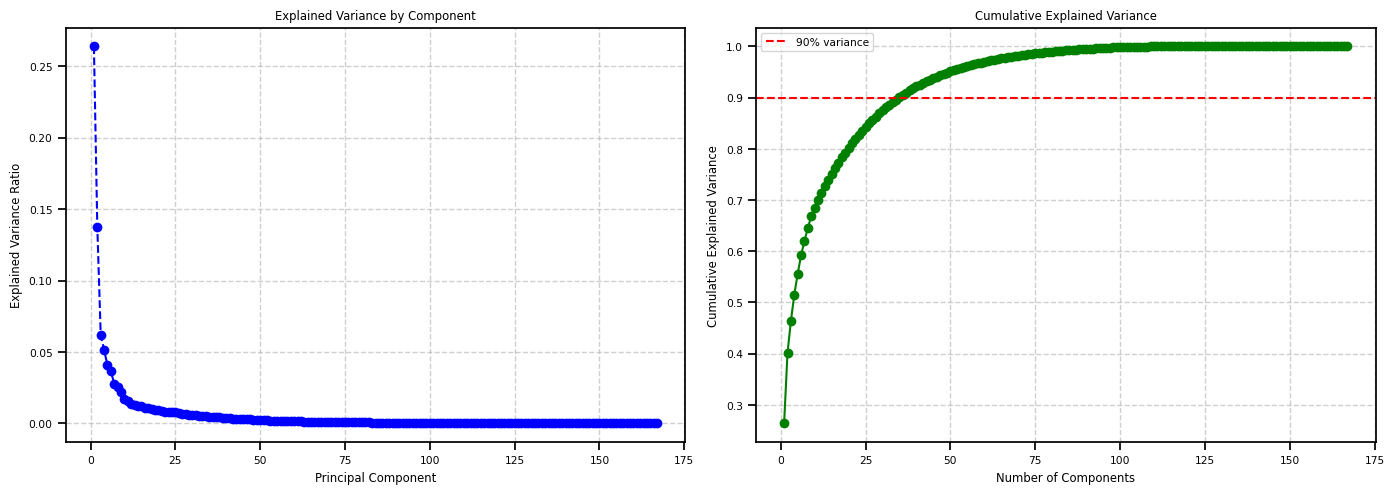

In [46]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA on processed data
pca = PCA()  # or e.g. PCA(n_components=0.9) to keep enough for 90%
X_train_pca = pca.fit_transform(X_train_processed)

# Transform val and test using the same PCA
X_val_pca = pca.transform(X_valid_processed)
X_test_pca = pca.transform(X_test_processed)

# Get explained variance ratio
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Explained variance per PC
axs[0].plot(range(1, len(explained_var)+1), explained_var, marker='o', linestyle='--', color='b')
axs[0].set_title('Explained Variance by Component')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Explained Variance Ratio')
axs[0].grid(True, linestyle='--', alpha=0.6)

# Cumulative variance
axs[1].plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', linestyle='-', color='g')
axs[1].axhline(y=0.9, color='r', linestyle='--', label='90% variance')
axs[1].set_title('Cumulative Explained Variance')
axs[1].set_xlabel('Number of Components')
axs[1].set_ylabel('Cumulative Explained Variance')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

4. Find number of components to reach 90%

In [47]:
# Find number of components for 90% variance
n_components_90 = np.argmax(cumulative_var >= 0.9) + 1
print(f"Number of components to explain 90% variance: {n_components_90}")

# Fit again keeping only those
pca_90 = PCA(n_components=n_components_90)
X_pca_90 = pca_90.fit_transform(X_train_processed)
print(f"Reduced shape: {X_pca_90.shape}")

Number of components to explain 90% variance: 35
Reduced shape: (45333, 35)


5. Reduce data to these components

In [49]:
from sklearn.decomposition import PCA

# Fit PCA again with the optimal number of components
pca = PCA(n_components=0.9)  # keep enough components for 90% variance
X_train_reduced = pca.fit_transform(X_train_processed)
X_val_reduced = pca.transform(X_valid_processed)
X_test_reduced = pca.transform(X_test_processed)

# ----------------------------------------------------------
# ✅ Print shapes to confirm
# ----------------------------------------------------------
print(f"Train reduced shape: {X_train_reduced.shape}")
print(f"Valid reduced shape: {X_val_reduced.shape}")
print(f"Test reduced shape : {X_test_reduced.shape}")


Train reduced shape: (45333, 35)
Valid reduced shape: (11569, 35)
Test reduced shape : (13938, 35)


6. View PCA Loadings heatmap

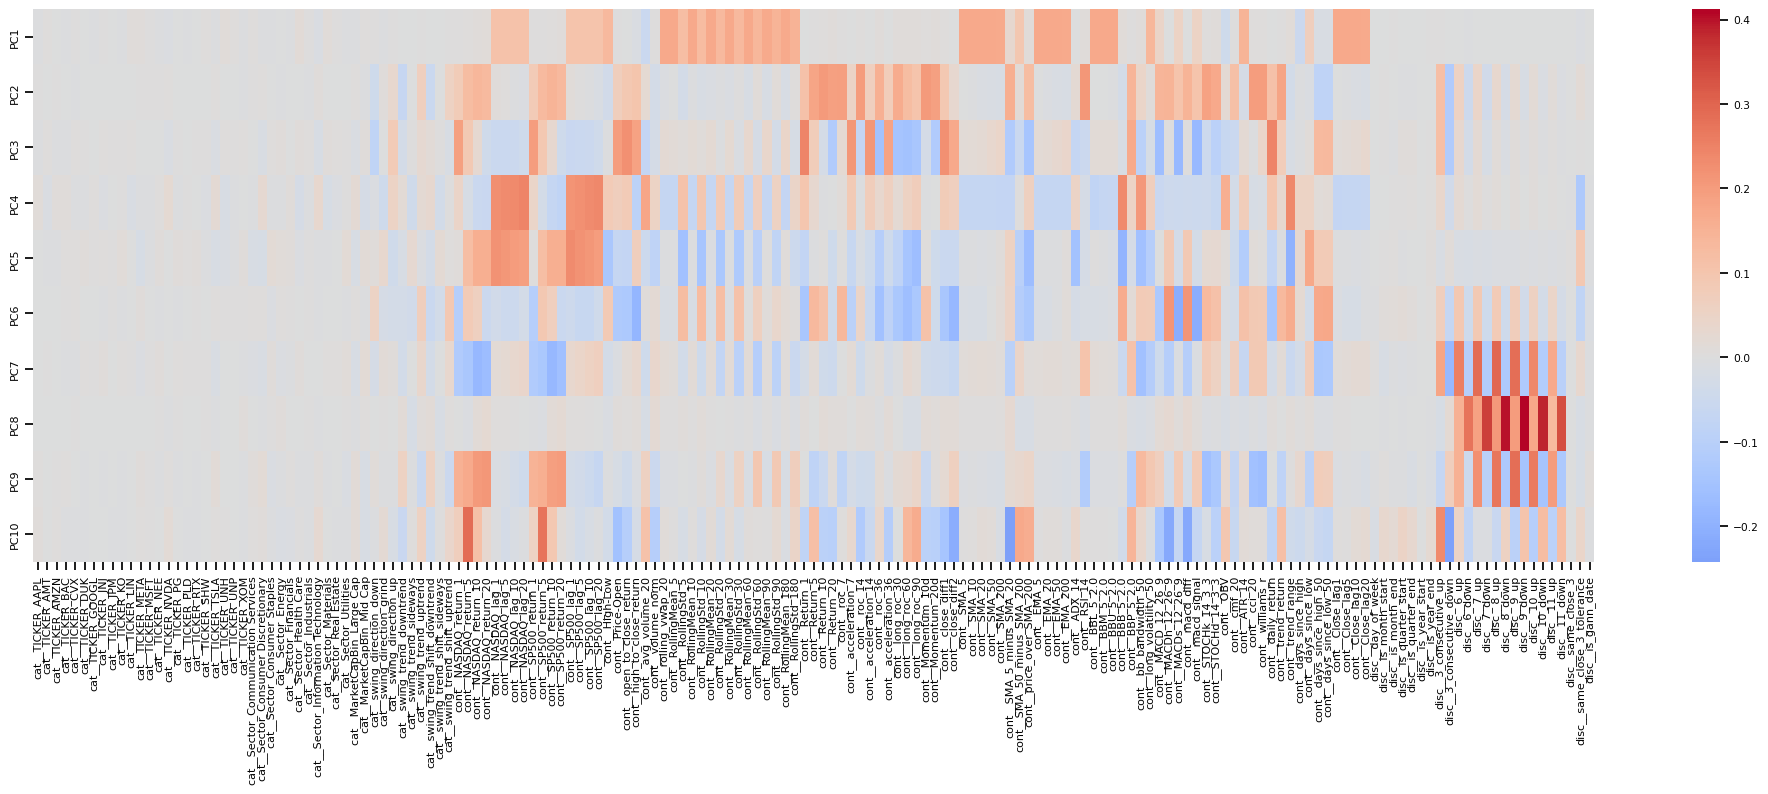

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get loadings (shape: n_components x n_features)
loadings = pca_90.components_

# Put into a DataFrame
feature_names = preprocessor.get_feature_names_out()
loadings_df = pd.DataFrame(loadings, columns=feature_names)

# Number of PCs to show
N_PCs_to_show = 10

# Control width and height explicitly here
width_in_inches = 20  # make it wider
height_in_inches = N_PCs_to_show * 0.8  # scale height by number of PCs

plt.figure(figsize=(width_in_inches, height_in_inches))

sns.heatmap(loadings_df.iloc[:N_PCs_to_show], 
            cmap="coolwarm", 
            center=0, 
            xticklabels=feature_names,
            yticklabels=[f'PC{i+1}' for i in range(N_PCs_to_show)])

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


7. Extract top features from PCA loadings

In [54]:
import numpy as np
import pandas as pd

# Set how many top features to take per PC
top_N_per_PC = 3

top_features_set = set()
for i in range(pca_90.n_components_):
    pc_loadings = np.abs(pca_90.components_[i])
    sorted_idx = np.argsort(pc_loadings)[::-1]
    top_features = np.array(feature_names)[sorted_idx[:top_N_per_PC]]
    top_features_set.update(top_features)

top_features_list = list(top_features_set)
print(f"Selected {len(top_features_list)} unique top features from PCA loadings.")
print("----------------------------------------------------------------------------------------------------------------------")
print("Top features from PCA loadings:")
for i in range(0, len(top_features_list), 10):
    print(", ".join(top_features_list[i:i+10])) 


Selected 62 unique top features from PCA loadings.
----------------------------------------------------------------------------------------------------------------------
Top features from PCA loadings:
cont__RSI_14, cont__open_to_close_return, disc__9_up, cont__NASDAQ_lag_20, cont__NASDAQ_return_5, cont__SP500_lag_1, cont__cmf_20, disc__is_year_end, cont__avg_volume_20, disc__same_close_3
cont__Price-Open, disc__10_up, cont__close_diff2, cont__MACDh_12_26_9, cont__BBU_5_2.0, cont__NASDAQ_return_20, cont__OBV, cont__trend_range, cont__SP500_return_5, cont__days_since_high
disc__6_down, cont__NASDAQ_lag_1, disc__same_close_3_tolerance, cont__Return_1, cont__BBB_5_2.0, cont__days_since_high_50, disc__11_down, disc__8_down, cont__macd_signal, disc__is_quarter_end
disc__10_down, disc__7_up, cont__volume_norm, disc__8_up, disc__3_consecutive_up, cont__ADX_14, cont__macd_diff, cont__SP500_return_10, disc__day_of_week, cont__Return_10
disc__is_month_end, disc__is_month_start, cont__SP500_retur

### Run UMAP on PCA embeddings

1. Calculate UMAP space

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

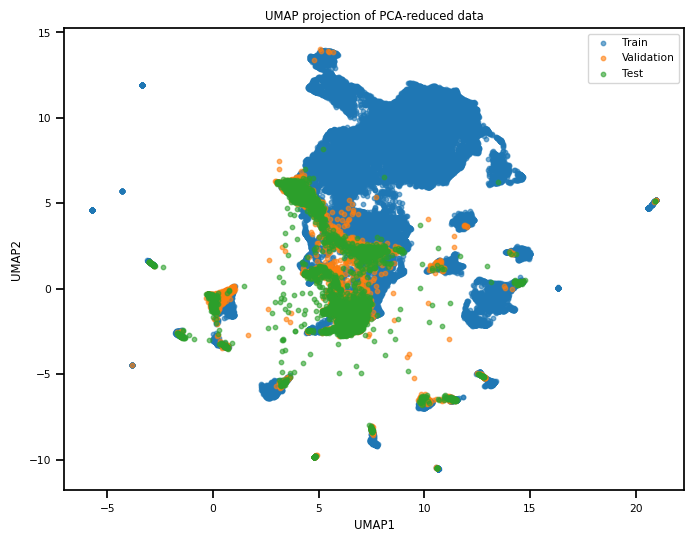

In [55]:
import umap
import matplotlib.pyplot as plt

# -----------------
# UMAP: embedding for visualization
# -----------------
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_train_umap = umap_embedder.fit_transform(X_train_reduced)
X_val_umap = umap_embedder.transform(X_val_reduced)
X_test_umap = umap_embedder.transform(X_test_reduced)

# Plot all together to see overlap
plt.figure(figsize=(8,6))
plt.scatter(X_train_umap[:,0], X_train_umap[:,1], s=10, alpha=0.6, label='Train')
plt.scatter(X_val_umap[:,0], X_val_umap[:,1], s=10, alpha=0.6, label='Validation')
plt.scatter(X_test_umap[:,0], X_test_umap[:,1], s=10, alpha=0.6, label='Test')
plt.title("UMAP projection of PCA-reduced data")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.show()



2. Run Elbow & Silhouette analysis on UMAP space


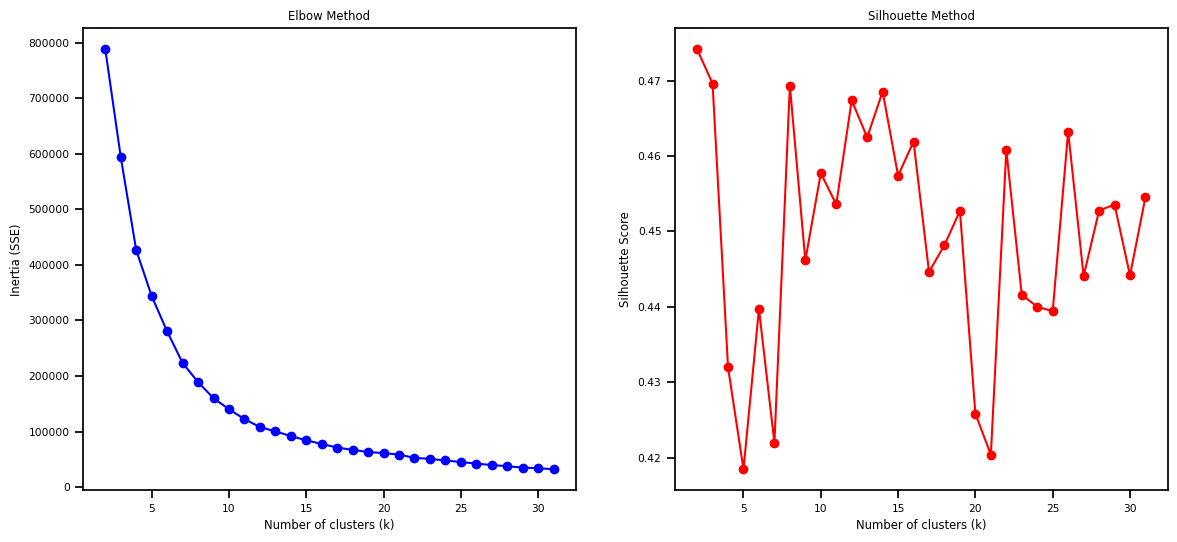

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

X_umap_array = np.array(X_train_umap)

elbow_scores = []
silhouette_scores = []
K_range = range(2, 32)  # e.g. 2 to 31 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_umap_array)
    inertia = kmeans.inertia_
    elbow_scores.append(inertia)

    sil_score = silhouette_score(X_umap_array, labels)
    silhouette_scores.append(sil_score)

# Plot Elbow
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(K_range, elbow_scores, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")

# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()


3. Automatically pick best k parameter


In [58]:
best_k = K_range[np.argmax(silhouette_scores)]
print(f"✅ Best k based on silhouette: {best_k}")

✅ Best k based on silhouette: 2


4. Fit final KMeans on UMAP with best k

First colour by newly identified clusters

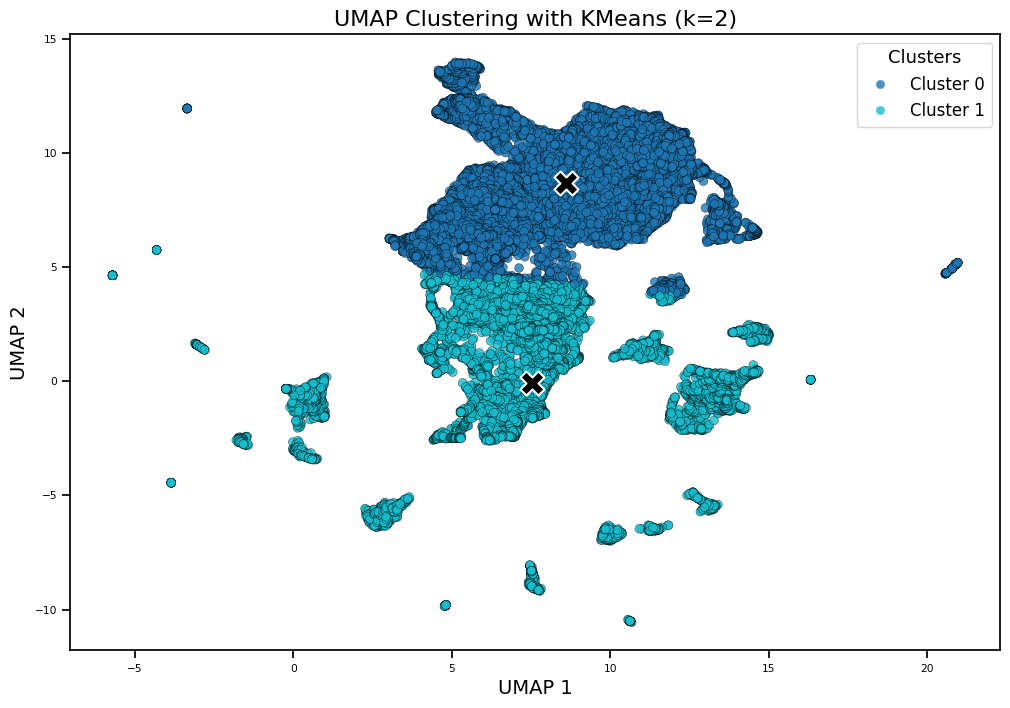

In [59]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Fit KMeans on UMAP embeddings
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_ids = final_kmeans.fit_predict(X_train_umap)

plt.figure(figsize=(12, 8))

# Scatter plot of UMAP points colored by cluster
scatter = plt.scatter(
    X_train_umap[:, 0],
    X_train_umap[:, 1],
    c=cluster_ids,
    cmap='tab10',
    s=40,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.3
)

# Plot cluster centers
plt.scatter(
    final_kmeans.cluster_centers_[:, 0],
    final_kmeans.cluster_centers_[:, 1],
    s=300,
    c='black',
    marker='X',
    label='Cluster Centers',
    edgecolor='white',
    linewidth=1.5
)

plt.title(f"UMAP Clustering with KMeans (k={best_k})", fontsize=16)
plt.xlabel("UMAP 1", fontsize=14)
plt.ylabel("UMAP 2", fontsize=14)

# Create legend with cluster numbers
handles, _ = scatter.legend_elements(prop="colors")
labels = [f"Cluster {i}" for i in range(best_k)]
plt.legend(handles, labels, title="Clusters", fontsize=12, title_fontsize=13, loc='best')

plt.show()


Now add the TICKER and Sector Info and colour by TICKER first

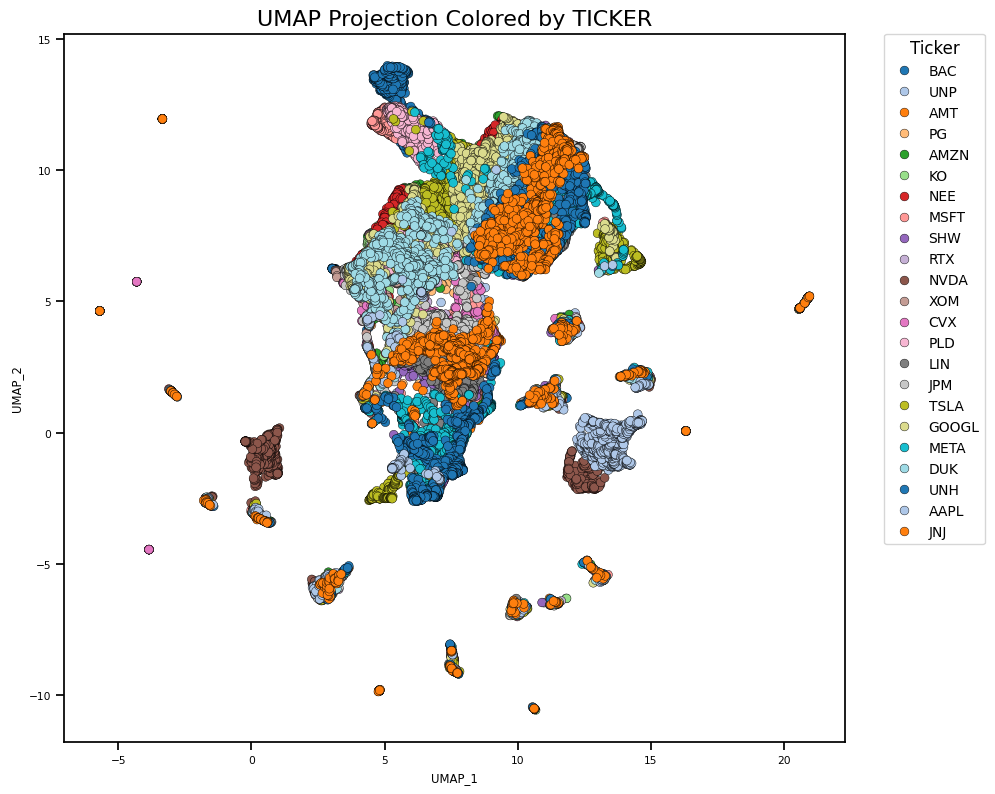

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume:
# - X_umap_array is your UMAP embeddings array (n_samples x 2)
# - cluster_ids is the array of cluster labels from KMeans
# - df is your filtered DataFrame used for PCA/UMAP that includes 'TICKER' and 'Sector' columns

# Step 1: Create DataFrame with UMAP coords and cluster IDs
X_train_umap = pd.DataFrame(X_umap_array, columns=['UMAP_1', 'UMAP_2'])
X_train_umap['Cluster_ID'] = cluster_ids

# Step 2: Add TICKER and Sector from your original (or filtered) DataFrame
# Important: the row order must be the same between X_umap_array and df
X_train_umap['TICKER'] = X_train_final['TICKER'].values
X_train_umap['Sector'] = X_train_final['Sector'].values

# plot colored by TICKER:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=X_train_umap,
    x='UMAP_1',
    y='UMAP_2',
    hue='TICKER',
    palette='tab20',
    s=40,
    edgecolor='k',
    linewidth=0.3
)
plt.title("UMAP Projection Colored by TICKER", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Ticker', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

And coloured by Sector

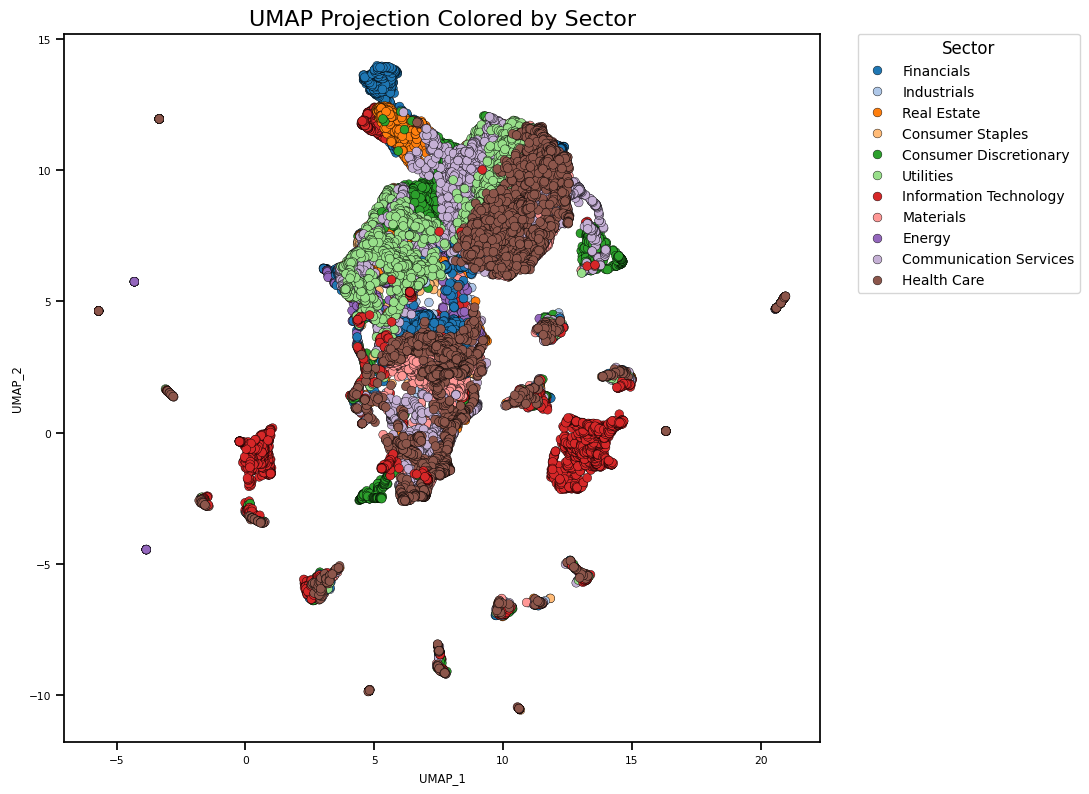

In [63]:
import seaborn as sns

# And colored by Sector:
plt.figure(figsize=(11, 8))
sns.scatterplot(
    data=X_train_umap,
    x='UMAP_1',
    y='UMAP_2',
    hue='Sector',
    palette='tab20',
    s=40,
    edgecolor='k',
    linewidth=0.3
)
plt.title("UMAP Projection Colored by Sector", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Sector', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()


It would appear that UMAP embeddings wouldn't be adding much of a useful information to the model. Based on best silhouette score of 2 and the fact that the later (more recent history) date data (validation and test set) cluster to one side of UMAP and all the other data points to the other side would imply that unsupervised clustering only captures temporal changes in data (expected for a time series). We will therefore explore some other methods for dimensionality reduction.

### Exploring supervised dimensionality reduction: Partial Least Squares (PLS)

PLS (Partial Least Squares) is like a supervised version of PCA.

- PCA: finds components that explain variance in X only (unsupervised).

- PLS: finds components that explain covariance between X and y.
It tries to find latent factors in X that best predict y.

Therefore:

The X_train_pls we obtain after pls.transform are our new features — these are linear combinations of the original features, chosen to be maximally predictive of y.

These components typically:

✅ Are fewer in number (5-10 vs hundreds of original features).
✅ Tend to be less "noisy".
✅ Can be directly fed into any regressor.

In [ ]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=5)
pls.fit(X_train_processed, y_train)

X_train_pls = pls.transform(X_train_processed)
X_val_pls = pls.transform(X_valid_processed)
X_test_pls = pls.transform(X_test_processed)


### Complete feature selection, integrated pipleine

Top features per PC:
PC1: ['BBU_5_2.0', 'EMA_50', 'RollingMean_30']
PC2: ['RSI_14', 'Momentum_10d', 'Return_10']
PC3: ['Return_1', 'daily_return', 'open_to_close_return']
PC4: ['trend_range', 'BBB_5_2.0', 'bb_bandwidth_50']
PC5: ['SP500_lag_1', 'NASDAQ_lag_1', 'SP500_lag_5']
PC6: ['MACDs_12_26_9', 'macd_signal', 'macd_diff']
PC7: ['8_up', '9_up', '7_up']
PC8: ['8_down', '9_down', '7_down']
PC9: ['9_up', 'NASDAQ_return_10', 'NASDAQ_return_5']
PC10: ['SMA_5_minus_SMA_20', 'MACDh_12_26_9', 'macd_diff']
PC11: ['is_quarter_end', 'is_month_end', 'is_year_end']
PC12: ['ADX_14', 'cmf_20', 'same_close_3_tolerance']
PC13: ['OBV', 'avg_volume_20', 'volume_norm']
PC14: ['is_quarter_start', 'is_month_start', 'OBV']
PC15: ['is_month_start', 'is_quarter_start', '3_consecutive_down']
PC16: ['OBV', 'avg_volume_20', 'cmf_20']
PC17: ['NASDAQ_return_1', 'SP500_return_1', 'days_since_low_50']
PC18: ['11_down', '6_down', '7_down']
PC19: ['11_up', '7_up', '6_up']
PC20: ['SMA_50_minus_SMA_200', 'close_diff2',

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



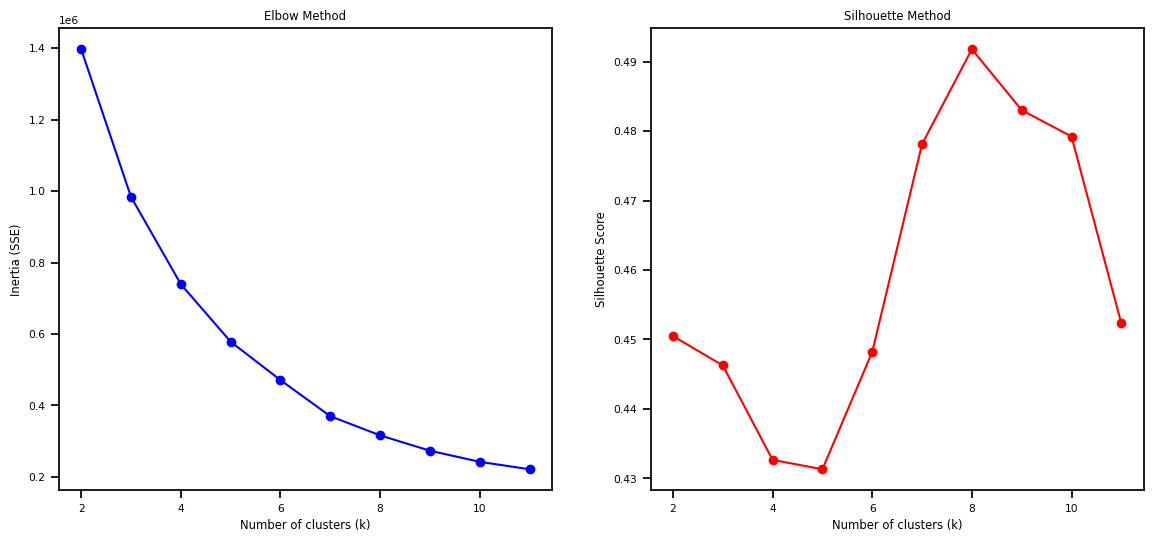

Best k based on silhouette: 8
Final DataFrame shape: (70840, 99)


,SP500_return_1,SMA_5_minus_SMA_20,11_down,days_since_low,days_since_low_50,day_of_week,acceleration_14,8_up,STOCHd_14_3_3,days_since_high,...,PC30,PC31,PC32,PC33,PC34,PC35,PC36,UMAP_1,UMAP_2,Cluster_ID
3335,0.001816,-0.000100,0,1017,14.0,4,3.128806,0,49.755810,1359,...,0.528008,0.815957,-0.582349,-0.164052,0.332815,2.378924,-0.019323,-3.907485,6.427886,5
3336,0.004481,0.106352,0,1018,15.0,5,-0.739920,0,66.066181,1360,...,0.617426,-0.446559,0.761560,-0.607873,0.101552,-0.276851,-0.541672,-7.797759,8.285112,5
3337,0.003249,0.208040,0,1019,16.0,1,-0.661225,0,78.266971,1361,...,1.263633,0.282539,-0.445036,-0.077460,0.020989,-0.203262,-0.973392,-7.991397,8.464228,5
3338,-0.002403,0.274761,0,1020,17.0,2,2.109725,0,80.154424,1362,...,0.097180,-0.010957,-0.332593,-0.150506,-0.189887,0.352420,0.513375,-7.719609,8.400898,5
3339,0.001314,0.304122,0,1021,18.0,3,3.827961,0,78.130405,1363,...,1.489332,0.056931,-0.503048,-0.267001,-0.214676,0.150674,-0.174450,-7.702130,8.395843,5


In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

# Assume X is your cleaned feature DataFrame (no targets, no leaky features)
# And categorical_features, discrete_features, continuous_features are defined based on X

# 1. Preprocess features
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
continuous_transformer = StandardScaler()
discrete_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('cont', continuous_transformer, continuous_features),
        ('disc', discrete_transformer, discrete_features)
    ],
    remainder='drop'
)

X_processed = preprocessor.fit_transform(X)

# 2. PCA transform
pca = PCA(n_components=36, random_state=42)
X_pca = pca.fit_transform(X_processed)

# 3. Extract top features from loadings for each PC (top 3 per PC here)
loadings = pca.components_  # shape (n_components, n_features)
feature_names = (
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    + continuous_features + discrete_features
)

top_features_per_pc = {}
top_n = 3

for i, comp in enumerate(loadings):
    sorted_indices = np.argsort(np.abs(comp))[::-1]  # descending abs loading
    top_features = [feature_names[idx] for idx in sorted_indices[:top_n]]
    top_features_per_pc[f'PC{i+1}'] = top_features

print("Top features per PC:")
for pc, feats in top_features_per_pc.items():
    print(f"{pc}: {feats}")

# 4. Run UMAP on PCA embeddings
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# 5. Determine best k via elbow + silhouette
elbow_scores = []
silhouette_scores = []
K_range = range(2, 12)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_umap)
    elbow_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_umap, labels))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, elbow_scores, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()

best_k = K_range[np.argmax(silhouette_scores)]
print(f"Best k based on silhouette: {best_k}")

# 6. Final clustering
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_ids = final_kmeans.fit_predict(X_umap)

# 7. Build final DataFrame
final_df = pd.DataFrame(index=X.index)

# Add selected original features - flatten top features per PC and take unique
selected_features = list({f for feats in top_features_per_pc.values() for f in feats})

# Make sure all selected features exist in X before selecting
selected_features = [f for f in selected_features if f in X.columns]

final_df[selected_features] = X[selected_features]

# Add PCA components
for i in range(X_pca.shape[1]):
    final_df[f'PC{i+1}'] = X_pca[:, i]

# Add UMAP coords
final_df['UMAP_1'] = X_umap[:, 0]
final_df['UMAP_2'] = X_umap[:, 1]

# Add cluster labels
final_df['Cluster_ID'] = cluster_ids

print(f"Final DataFrame shape: {final_df.shape}")
final_df.head()


Add 'TICKER', 'Sector', 'MarketCapBin' back in for modelling and 'Date' to enable data split

1. View final features

In [315]:
# Total number of features in final_df
print(f"Total number of features in final_df: {len(final_df.columns)}") 
# neatly print all features in X
print("---------------------------------------------------------------------------------------------------------------------")
print("List of all features in X:")
print("---------------------------------------------------------------------------------------------------------------------")
clean_features = final_df.columns.to_list() 
# List of all features in X as a Python list
for i in range(0, len(clean_features), 10):
    print(", ".join(clean_features[i:i+10]))
    

Total number of features in final_df: 103
---------------------------------------------------------------------------------------------------------------------
List of all features in X:
---------------------------------------------------------------------------------------------------------------------
SP500_return_1, SMA_5_minus_SMA_20, 11_down, days_since_low, days_since_low_50, day_of_week, acceleration_14, 8_up, STOCHd_14_3_3, days_since_high
NASDAQ_return_5, acceleration_36, BBB_5_2.0, bb_bandwidth_50, 8_down, Return_10, 11_up, RollingMean_30, NASDAQ_return_10, RSI_14
6_up, is_gann_date, EMA_50, days_since_high_50, NASDAQ_lag_1, close_diff2, MACDs_12_26_9, macd_diff, SP500_return_5, SMA_50_minus_SMA_200
Price-Open, daily_return, trend_range, volume_norm, same_close_3, SP500_lag_5, 7_up, 9_down, cmf_20, same_close_3_tolerance
NASDAQ_return_1, BBU_5_2.0, Momentum_10d, open_to_close_return, SP500_lag_1, MACDh_12_26_9, macd_signal, ADX_14, is_month_start, is_year_end
6_down, is_quart

### Making Decision on whether one unified model can work or should we consider a different approach

<span style="color:pink"> 💡 The fundamental problem is that I want to decide on whether: </span>

➡️ I should train:
- (A) One big global model for all stocks & sectors?
- (B) A separate model per TICKER or SECTOR?

This is hugely important because:
- (A) has more data and learns general patterns (more stable), but risks underfitting each stock’s idiosyncrasies.
- (B) captures each ticker/sector nuance, but can overfit or fail due to not enough data.

1. Hot encoding sector, ticker, market cap bin

In [318]:
import pandas as pd

# One-hot encode
encoded_df = pd.get_dummies(final_df, columns=['Sector', 'TICKER', 'MarketCapBin'])

# check result
print(encoded_df.shape)
encoded_df.head()

encoded_features = encoded_df.columns.to_list() 
# List of all features in encoded as a Python list
for i in range(0, len(encoded_features), 10):
    print(", ".join(encoded_features[i:i+10]))


(70840, 136)
SP500_return_1, SMA_5_minus_SMA_20, 11_down, days_since_low, days_since_low_50, day_of_week, acceleration_14, 8_up, STOCHd_14_3_3, days_since_high
NASDAQ_return_5, acceleration_36, BBB_5_2.0, bb_bandwidth_50, 8_down, Return_10, 11_up, RollingMean_30, NASDAQ_return_10, RSI_14
6_up, is_gann_date, EMA_50, days_since_high_50, NASDAQ_lag_1, close_diff2, MACDs_12_26_9, macd_diff, SP500_return_5, SMA_50_minus_SMA_200
Price-Open, daily_return, trend_range, volume_norm, same_close_3, SP500_lag_5, 7_up, 9_down, cmf_20, same_close_3_tolerance
NASDAQ_return_1, BBU_5_2.0, Momentum_10d, open_to_close_return, SP500_lag_1, MACDh_12_26_9, macd_signal, ADX_14, is_month_start, is_year_end
6_down, is_quarter_end, OBV, Return_1, 3_consecutive_down, avg_volume_20, 7_down, is_quarter_start, 9_up, is_month_end
PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10
PC11, PC12, PC13, PC14, PC15, PC16, PC17, PC18, PC19, PC20
PC21, PC22, PC23, PC24, PC25, PC26, PC27, PC28, PC29, PC30
PC31, PC32, PC33, PC3